In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

## Data clean

df = pd.read_csv(r"C:\Users\Roman Shypka\OneDrive\Робочий стіл\car_price_prediction_with_missing.csv")

In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2250 entries, 0 to 2499
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Car ID                  2250 non-null   float64
 1   Brand                   2250 non-null   object 
 2   Year                    2250 non-null   float64
 3   Engine Size             2250 non-null   float64
 4   Fuel Type               2250 non-null   object 
 5   Transmission            2250 non-null   object 
 6   Mileage                 2250 non-null   float64
 7   Condition               2250 non-null   object 
 8   Price                   2250 non-null   float64
 9   Model                   2250 non-null   object 
 10  Condition_Encoded       2250 non-null   int64  
 11  Condition_transmission  2250 non-null   int64  
 12  Brand_Audi              2250 non-null   int64  
 13  Brand_BMW               2250 non-null   int64  
 14  Brand_Ford              2250 non-null   int64

In [249]:
df.columns

Index(['Car ID', 'Brand', 'Year', 'Engine Size', 'Fuel Type', 'Transmission',
       'Mileage', 'Condition', 'Price', 'Model', 'Condition_Encoded',
       'Condition_transmission', 'Brand_Audi', 'Brand_BMW', 'Brand_Ford',
       'Brand_Honda', 'Brand_Mercedes', 'Brand_Tesla', 'Brand_Toyota',
       'Brand_Audi', 'Brand_BMW', 'Brand_Ford', 'Brand_Honda',
       'Brand_Mercedes', 'Brand_Tesla', 'Brand_Toyota'],
      dtype='object')

In [250]:
df.describe() ## describe all columns 

,Car ID,Year,Engine Size,Mileage,Price,Condition_Encoded,Condition_transmission,Brand_Audi,Brand_BMW,Brand_Ford,...,Brand_Mercedes,Brand_Tesla,Brand_Toyota,Brand_Audi,Brand_BMW,Brand_Ford,Brand_Honda,Brand_Mercedes,Brand_Tesla,Brand_Toyota
count,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,...,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000
mean,1251.243556,2011.577778,3.485467,150236.178222,52506.874391,0.984889,0.473778,0.143556,0.144889,0.136444,...,0.147111,0.139556,0.153778,0.143556,0.144889,0.136444,0.134667,0.147111,0.139556,0.153778
std,725.637358,6.980468,1.427690,88150.746556,27232.417079,0.817627,0.499423,0.350716,0.352067,0.343336,...,0.354295,0.346602,0.360816,0.350716,0.352067,0.343336,0.341443,0.354295,0.346602,0.360816
min,1.000000,2000.000000,1.000000,15.000000,5011.270000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,627.250000,2005.000000,2.300000,71178.500000,28985.052500,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1249.500000,2012.000000,3.450000,149762.000000,53485.240000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1875.250000,2018.000000,4.700000,226299.000000,75560.340000,2.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2500.000000,2023.000000,6.000000,299967.000000,99982.590000,2.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [231]:
df.isnull().sum() # Quantity null value 

Car ID                    0
Brand                     0
Year                      0
Engine Size               0
Fuel Type                 0
Transmission              0
Mileage                   0
Condition                 0
Price                     0
Model                     0
Condition_Encoded         0
Condition_transmission    0
Brand_Audi                0
Brand_BMW                 0
Brand_Ford                0
Brand_Honda               0
Brand_Mercedes            0
Brand_Tesla               0
Brand_Toyota              0
dtype: int64

In [ ]:
df = df.dropna(how="all") # delete null value 

 ## Data analysis

In [232]:
df["Price"].sort_values(ascending=False)  # max price cars


1706    99982.59
1564    99968.62
917     99905.90
1763    99794.46
2272    99578.74
          ...   
1460     5247.71
1803     5107.22
1779     5060.75
2166     5022.86
875      5011.27
Name: Price, Length: 2250, dtype: float64

In [233]:
df["Price"].sort_values(ascending=True) # min price cars

875      5011.27
2166     5022.86
1779     5060.75
1803     5107.22
1460     5247.71
          ...   
2272    99578.74
1763    99794.46
917     99905.90
1564    99968.62
1706    99982.59
Name: Price, Length: 2250, dtype: float64

In [236]:
df_corr = df_numeric.corr()
df_corr["Price"].sort_values(ascending=False)  ## correletion price 

Price                     1.000000
Brand_BMW                 0.024891
Brand_Mercedes            0.008742
Car ID                    0.006645
Brand_Tesla               0.002530
Brand_Audi               -0.003781
Condition_transmission   -0.008332
Brand_Toyota             -0.008839
Mileage                  -0.009638
Brand_Honda              -0.010063
Condition_Encoded        -0.010496
Engine Size              -0.013270
Brand_Ford               -0.013942
Year                     -0.035127
Name: Price, dtype: float64

## Preparation of data for the model 

In [228]:
df["Condition"].unique() 

array(['New', 'Used', 'Like New'], dtype=object)

In [251]:
#Mapping categorical features to numerical values
condition_mapping = {"Used": 0 , "Like New": 1, "New" : 2}
condition_transmission = {'Manual': 0 , 'Automatic': 1}
#Applying the mapping to create features for model 
df["condition_mapping"]= df["Condition"].map(condition_mapping)
df["transmission_mapping"] = df["Transmission"].map(condition_transmission)  # 
df.head(5)


,Car ID,Brand,Year,Engine Size,Fuel Type,Transmission,Mileage,Condition,Price,Model,...,Brand_Toyota,Brand_Audi,Brand_BMW,Brand_Ford,Brand_Honda,Brand_Mercedes,Brand_Tesla,Brand_Toyota,condition_mapping,transmission_mapping
0,1.0,Tesla,2016.0,2.3,Petrol,Manual,114832.0,New,26613.92,Model X,...,0,0,0,0,0,0,1,0,2,0
1,2.0,BMW,2018.0,4.4,Electric,Manual,143190.0,Used,14679.61,5 Series,...,0,0,1,0,0,0,0,0,0,0
2,3.0,Audi,2013.0,4.5,Electric,Manual,181601.0,New,44402.61,A4,...,0,1,0,0,0,0,0,0,2,0
3,4.0,Tesla,2011.0,4.1,Diesel,Automatic,68682.0,New,86374.33,Model Y,...,0,0,0,0,0,0,1,0,2,1
4,5.0,Ford,2009.0,2.6,Diesel,Manual,223009.0,Like New,73577.10,Mustang,...,0,0,0,1,0,0,0,0,1,0


In [234]:
df_numeric = df.select_dtypes(include=["number"]) # create new dataframe with only numbers , for correlation 



In [235]:
df_numeric.head(5)

,Car ID,Year,Engine Size,Mileage,Price,Condition_Encoded,Condition_transmission,Brand_Audi,Brand_BMW,Brand_Ford,Brand_Honda,Brand_Mercedes,Brand_Tesla,Brand_Toyota
0,1.0,2016.0,2.3,114832.0,26613.92,2,0,0,0,0,0,0,1,0
1,2.0,2018.0,4.4,143190.0,14679.61,0,0,0,1,0,0,0,0,0
2,3.0,2013.0,4.5,181601.0,44402.61,2,0,1,0,0,0,0,0,0
3,4.0,2011.0,4.1,68682.0,86374.33,2,1,0,0,0,0,0,1,0
4,5.0,2009.0,2.6,223009.0,73577.10,1,0,0,0,1,0,0,0,0


In [243]:
 df["Brand"].unique()

array(['Tesla', 'BMW', 'Audi', 'Ford', 'Honda', 'Mercedes', 'Toyota'],
      dtype=object)

In [244]:
brand_dummies = pd.get_dummies(df["Brand"],prefix="Brand",dtype=int) # add new columns with prefix Brand , to avoid  repetition names columns 
brand_dummies

,Brand_Audi,Brand_BMW,Brand_Ford,Brand_Honda,Brand_Mercedes,Brand_Tesla,Brand_Toyota
0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
2494,0,0,0,0,1,0,0
2495,1,0,0,0,0,0,0
2496,1,0,0,0,0,0,0
2498,1,0,0,0,0,0,0


In [245]:
df= pd.concat([df,brand_dummies],axis=1) #association new columns with global dataframe 

Text(0, 0.5, 'Predict Price')

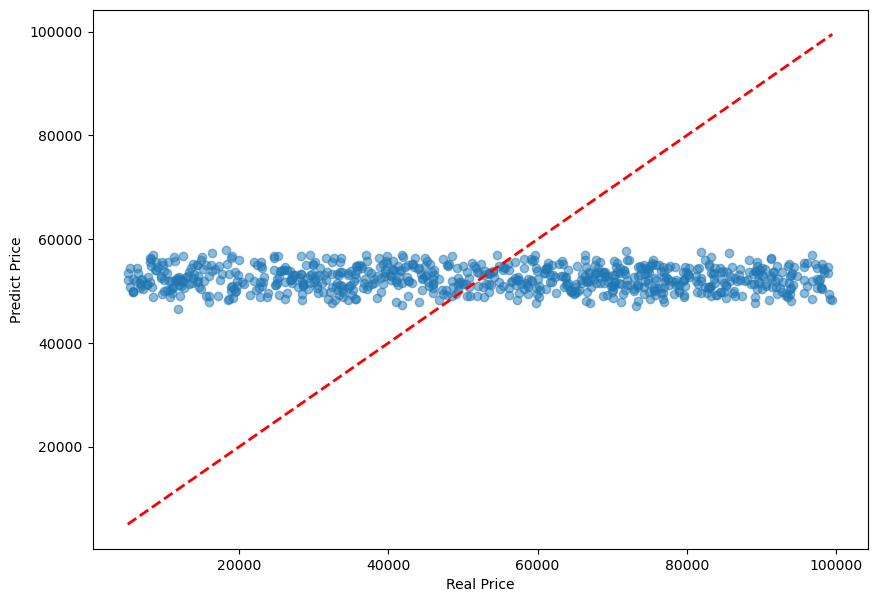

In [241]:
plt.figure(figsize=(10,7))
plt.scatter(y_test,predictions,alpha=0.5) #create graph 
plt.plot([y_test.min() , y_test.max()],[y_test.min() , y_test.max()], "r--",lw=2) ## create plot for graph
plt.xlabel("Real Price")
plt.ylabel("Predict Price")

## Model training

In [237]:
X = df_numeric[["Year","Engine Size","Mileage","Condition_Encoded","Condition_transmission",'Brand_Audi', 'Brand_BMW', 'Brand_Ford', 'Brand_Honda', 'Brand_Mercedes', 'Brand_Tesla', 'Brand_Toyota']]
y = df_numeric[["Price"]]

In [258]:
# splittin the dataframe into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#initializing the LinearRegression Model
model = LinearRegression() 
# Training the model on training data
model.fit(X_train,y_train)


LinearRegression()

In [259]:
#making predictions on the unseen data
predictions = model.predict(X_test)

In [260]:
erorr_mean = mean_absolute_error(y_test,predictions)
erorr_mean  

23659.417375386183